<a href="https://colab.research.google.com/github/HenningGC/StocksFromETFsScraper/blob/main/finviz_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
import lxml
from lxml import etree
from lxml import html
from urllib.request import urlopen, Request
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# FINVIZ Implementation

Select ETF for which you want to see the relative strength of its holdings: spy
['spy']
AMZN
BRK-B
LLY
AAPL
GOOG
MSFT
AVGO
META
GOOGL
NVDA


<ipython-input-48-dae0fa5b3e08>:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (df['52 Week Low'][i], df['52 Week High'][i]))


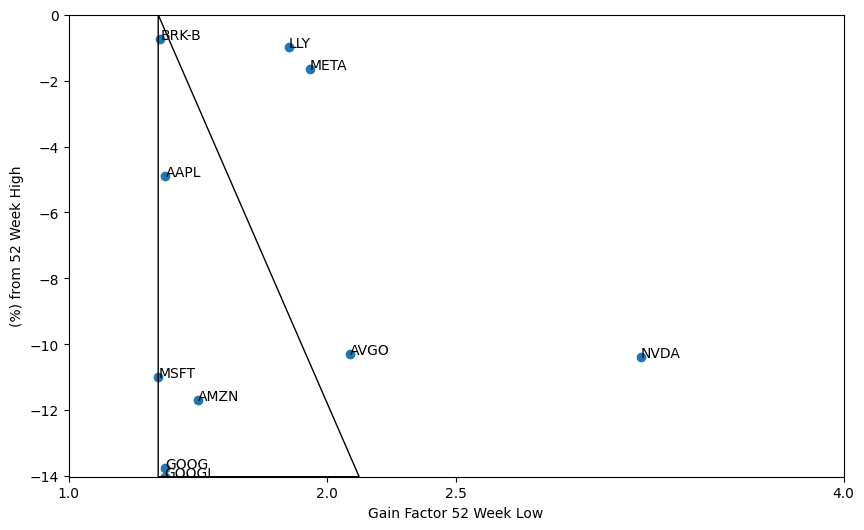





Would you like to analyze leadership of other ETF data?: n


In [48]:

def main():
    answer = str(input("Select ETF for which you want to see the relative strength of its holdings: ")).lower().split(' ')
    print(answer)
    VisualizeData(scrape_stocks(answer))

def scrape_stocks(ETF):
    perfData = pd.DataFrame()
    # perfData['Symbol'] = ""
    vals = list()
    for elem in ETF:
        url = 'https://finviz.com/api/etf_holdings/{}/top_ten'.format(elem)

        #req = Request(url=url,headers={'user-agent':'my-app'})
        response = requests.get(url, headers={'user-agent':'my-app'}).json()
        data = response['rowData']

        for i in range(len(data)):
            val = data[i]
            vals.append(val['ticker'])
    AllData = pd.DataFrame()
    for i,ticker in enumerate(set(vals)):

        req = Request(url='https://finviz.com/quote.ashx?t={}'.format(ticker),headers={'user-agent':'my-app'})
        try:
            response = urlopen(req)

        except:
            continue
        print(ticker)
        html = BeautifulSoup(response, 'html')
        info_table = html.find_all(class_= "snapshot-table2")

        info_tables = dict()

        info_tables[ticker] = info_table

        ticker_data = info_tables[ticker]

        ticker_rows = [result.findAll('tr') for result in ticker_data]
        ticker_rows_content = [result.findAll('b') for result in ticker_data]

        numbers = [item.text for item in ticker_rows_content[0]]
        numbers = [item.replace('%','') if '%' in item else item for item in numbers]

        data = {
            'Perf Month': numbers[11],
            'Perf Year': numbers[29],
            'W High': numbers[40],
            'W Low': numbers[46],
            'Price': numbers[71]
        }


        AllData[ticker] = [data['Perf Month'],data['Perf Year'],data['W Low'],data['W High'],data['Price']]

    return(AllData)


def VisualizeData(df):

    # Transpose original
    df = pd.DataFrame(df.T)

    df = df.rename(columns={0:'1 Month Returns', 1:'1 Year Returns', 2:'52 Week Low',3:'52 Week High',4:'Price'})

    df.loc[df['1 Year Returns'] == '-', ['1 Month Returns','1 Year Returns']] = np.nan


    # df = df.drop(df[df['1 Year Returns'] == '-'].index)

    df[['1 Month Returns','1 Year Returns','52 Week Low','52 Week High','Price']] = df[['1 Month Returns','1 Year Returns','52 Week Low','52 Week High','Price']].astype(float)

    noNA_df = df[~np.isnan(df['1 Month Returns'])]
    # print(noNA_df)

    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(x = df['52 Week Low'], y = df['52 Week High'])
    # plt.ylim(min(df['52 Week High']), max(df['52 Week High']))
    plt.ylim(min(df['52 Week High']), 0)

    x_ticks = [0,100,150,300]
    x_labels = ['1.0','2.0','2.5','4.0']
    plt.xticks(x_ticks,x_labels)


    ax.add_patch(Polygon([[min(df['52 Week Low']),min(df['52 Week High'])],[min(df['52 Week Low']),0],[112.5,min(df['52 Week High'])]], closed=True,fill=False))


    plt.xlabel('Gain Factor 52 Week Low')
    plt.ylabel('(%) from 52 Week High') # CIBR PSJ SOCL PNQI SKYY AIQ

    for i, txt in enumerate(df.index):

        ax.annotate(txt, (df['52 Week Low'][i], df['52 Week High'][i]))


    plt.show()
    print(f'\n')
    print(f'\n')
    answer = str(input("Would you like to analyze leadership of other ETF data?: ")).lower().strip()

    while answer not in ('y','yes','n','no'):
        answer = str(input("Would you like to analyze leadership of other ETF data?: ")).lower().strip()
    if answer in ('y','yes'):
        main()
    elif answer in ('n','no'):
        exit()

main()

# ETF Channel Implementation

In [9]:
from bs4 import BeautifulSoup

def get_pagination(response_text):

  html_content = response_text

  # Parse the HTML content using BeautifulSoup
  soup = BeautifulSoup(html_content, 'html.parser')

  # Locate the pagination links (all <a> tags within the pagination element)
  pagination_links = soup.select('td[align="right"] span a')

  hrefs = []

  # Extract the href attribute from each pagination link
  for link in pagination_links:
    href = link.get('href')

    if href:
      hrefs.append(href)

  return hrefs



In [10]:
from bs4 import BeautifulSoup

def extract_data(response_text):
  soup = BeautifulSoup(response_text, 'html.parser')


  etf_links = soup.find_all('a', href=True)


  etf_list = []


  for link in etf_links:
      href = link['href']

      if '/symbol/' in href:
          #etf_name = link.text.strip()
          etf_symbol = href.split('/symbol/')[-1]
          etf_list.append(etf_symbol)

  return etf_list


In [28]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def VisualizeData(df):

    # Transpose original
    df = pd.DataFrame(df.T)

    df = df.rename(columns={0: '1 Month Returns', 1: '1 Year Returns', 2: '52 Week Low', 3: '52 Week High', 4: 'Price'})

    df.loc[df['1 Year Returns'] == '-', ['1 Month Returns', '1 Year Returns']] = np.nan

    df[['1 Month Returns', '1 Year Returns', '52 Week Low', '52 Week High', 'Price']] = df[
        ['1 Month Returns', '1 Year Returns', '52 Week Low', '52 Week High', 'Price']].astype(float)

    noNA_df = df[~np.isnan(df['1 Month Returns'])]

    # Create the figure
    fig = go.Figure()

    # Scatter plot
    fig.add_trace(go.Scatter(
        x=df['52 Week Low'],
        y=df['52 Week High'],
        mode='markers+text',
        text=df.index,
        textposition='top center',
        marker=dict(size=10, color='blue', line=dict(width=2))
    ))

    # Add polygon
    fig.add_trace(go.Scatter(
        x=[min(df['52 Week Low']), min(df['52 Week Low']), 112.5],
        y=[min(df['52 Week High']), 0, min(df['52 Week High'])],
        fill="toself",
        mode='lines',
        line=dict(color='gray'),
        fillcolor='rgba(128, 128, 128, 0.1)',
        name='Polygon'
    ))

    # Update axes labels
    fig.update_layout(
        title="Interactive Scatter Plot of Assets",
        xaxis_title="Gain Factor 52 Week Low",
        yaxis_title="(%) from 52 Week High",
        yaxis=dict(range=[min(df['52 Week High']), max(df['52 Week High'])]),  # Set the correct y-axis range
        xaxis=dict(
            tickvals=[0, 100, 150, 300],
            ticktext=['1.0', '2.0', '2.5', '4.0']
        ),
        template="plotly_white",
        height=800,  # Increased height
        width=1200   # Increased width
    )

    # Show the interactive plot
    fig.show()


In [14]:
def scrape_stocks_get_returns():
    answer = str(input("Select ETF for which you want to see the relative strength of its holdings: ")).lower().split(' ')
    print(answer)
    session = requests.Session()
    tickers = get_tickers(answer, session)
    returns = get_returns(tickers)

    return returns

def get_tickers(ETF, session):
    perfData = pd.DataFrame()
    # perfData['Symbol'] = ""
    url = 'https://www.etfchannel.com/lists/?a=stockholdings&symbol={}'.format(ETF[0])

    #req = Request(url=url,headers={'user-agent':'my-app'})
    session_response = session.get(url, headers={
      "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
      "accept-encoding": "gzip, deflate, br, zstd",
      "accept-language": "es-ES,es;q=0.9,en-US;q=0.8,en;q=0.7",
      "connection": "keep-alive",
      "cookie": "coregval=ims; slogin=1724346539; slogin=1724346539",
      "host": "www.etfchannel.com",
      "sec-ch-ua": '"Not)A;Brand";v="99", "Google Chrome";v="127", "Chromium";v="127"',
      "sec-ch-ua-mobile": "?0",
      "sec-ch-ua-platform": '"macOS"',
      "sec-fetch-dest": "document",
      "sec-fetch-mode": "navigate",
      "sec-fetch-site": "none",
      "sec-fetch-user": "?1",
      "upgrade-insecure-requests": "1",
      "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36"})

    vals = extract_data(session_response.text)
    paginations = set(get_pagination(session_response.text))

    session.cookies.clear()

    for pagination in paginations:
      session = requests.Session()

      url = 'https://www.etfchannel.com'+pagination
      session_response = session.get(url, headers={
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "accept-encoding": "gzip, deflate, br, zstd",
        "accept-language": "es-ES,es;q=0.9,en-US;q=0.8,en;q=0.7",
        "connection": "keep-alive",
        "cookie": "coregval=ims; slogin=1724346539; slogin=1724346539",
        "host": "www.etfchannel.com",
        "sec-ch-ua": '"Not)A;Brand";v="99", "Google Chrome";v="127", "Chromium";v="127"',
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": '"macOS"',
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "none",
        "sec-fetch-user": "?1",
        "upgrade-insecure-requests": "1",
        "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36"})

      vals.extend(extract_data(session_response.text))
      session.cookies.clear()
    return vals

def get_returns(tickers):

  AllData = pd.DataFrame()
  for i,ticker in enumerate(set(tickers)):

      req = Request(url='https://finviz.com/quote.ashx?t={}'.format(ticker),headers={'user-agent':'my-app'})
      try:
          response = urlopen(req)

      except:
          continue
      print(ticker)
      html = BeautifulSoup(response, 'html')
      info_table = html.find_all(class_= "snapshot-table2")

      info_tables = dict()

      info_tables[ticker] = info_table

      ticker_data = info_tables[ticker]

      ticker_rows = [result.findAll('tr') for result in ticker_data]
      ticker_rows_content = [result.findAll('b') for result in ticker_data]

      numbers = [item.text for item in ticker_rows_content[0]]
      numbers = [item.replace('%','') if '%' in item else item for item in numbers]

      data = {
          'Perf Month': numbers[11],
          'Perf Year': numbers[29],
          'W High': numbers[40],
          'W Low': numbers[46],
          'Price': numbers[71]
      }


      AllData[ticker] = [data['Perf Month'],data['Perf Year'],data['W Low'],data['W High'],data['Price']]

  return(AllData)

In [31]:
returns = scrape_stocks_get_returns()

Select ETF for which you want to see the relative strength of its holdings: xlu
['xlu']
etr
d
ed
pcg
aee
duk
fe
nee
eix
aes
so
evrg
cms
ato
awk
xel
ppl
dte
nrg
ni
aep
sre
vst
wec
lnt
ceg
exc
pnw
es
peg
cnp


In [32]:
VisualizeData(returns)